In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ==========================================================
# 0. Environment Setup
# ==========================================================
!git clone https://github.com/Minxing-Zheng/CMU_10701_GroupProject.git
%cd CMU_10701_GroupProject

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# 自己的模块
from models.lambdamart_ranker import LambdaMARTRanker, LambdaMARTConfig
from utils.split_utils import split_query_dict
from utils.fdp_eval import compute_fdp, find_lambda_hat

Cloning into 'CMU_10701_GroupProject'...
remote: Enumerating objects: 129, done.
remote: Total 129 (delta 0), reused 0 (delta 0), pack-reused 129 (from 1)
Receiving objects: 100% (129/129), 43.57 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/CMU_10701_GroupProject


In [12]:
# ==========================================================
# 1. 读取 Microsoft MSLR-WEB10K (Fold1) 数据
# ==========================================================
from scipy import sparse

def load_svmlight_with_qid(path):
    labels, qids, rows, cols, data = [], [], [], [], []
    max_f = 0
    with open(path, "r") as f:
        for r, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            y = float(parts[0]); labels.append(y)
            qtok = next((t for t in parts[1:] if t.startswith("qid:")), None)
            if qtok is None:
                raise ValueError(f"No qid token in line:\n{line[:80]}...")
            qids.append(int(qtok.split(":")[1]))
            for tok in parts[1:]:
                if tok.startswith("qid:"):
                    continue
                i, v = tok.split(":")
                c = int(i) - 1
                rows.append(r); cols.append(c); data.append(float(v))
                if c > max_f: max_f = c
    X = sparse.csr_matrix((data, (rows, cols)), shape=(len(labels), max_f+1), dtype=np.float32)
    y = np.asarray(labels, dtype=np.float32)
    q = np.asarray(qids, dtype=np.int64)
    return X, y, q

# ========== 数据路径 (Microsoft MSLR-WEB10K Fold1) ==========
ROOT = "/content/drive/MyDrive/701_project/MS/Fold1"
train_path = os.path.join(ROOT, "train.txt")
valid_path = os.path.join(ROOT, "vali.txt")
test_path  = os.path.join(ROOT, "test.txt")

X_tr, y_tr, q_tr = load_svmlight_with_qid(train_path)
X_vl, y_vl, q_vl = load_svmlight_with_qid(valid_path)
X_te, y_te, q_te = load_svmlight_with_qid(test_path)

print("="*60)
print("DATA DIAGNOSTICS")
print("="*60)
print(f"Shapes — train: {X_tr.shape}, valid: {X_vl.shape}, test: {X_te.shape}")
print(f"Number of features: {X_tr.shape[1]}")
print()

# 检查label分布
print("Label distribution:")
for name, y in [("train", y_tr), ("valid", y_vl), ("test", y_te)]:
    unique, counts = np.unique(y, return_counts=True)
    print(f"  {name}: {dict(zip(unique.astype(int), counts))}")
print()

# 检查query数量
print("Query counts:")
print(f"  train: {len(np.unique(q_tr))} queries")
print(f"  valid: {len(np.unique(q_vl))} queries")
print(f"  test:  {len(np.unique(q_te))} queries")
print()

# 检查每个query的文档数
docs_per_query_tr = pd.Series(q_tr).value_counts()
print(f"Docs per query (train): min={docs_per_query_tr.min()}, max={docs_per_query_tr.max()}, mean={docs_per_query_tr.mean():.1f}")

# 检查特征是否有NaN或Inf
X_tr_dense = X_tr.toarray()
print(f"\nFeature checks (train):")
print(f"  NaN count: {np.isnan(X_tr_dense).sum()}")
print(f"  Inf count: {np.isinf(X_tr_dense).sum()}")
print(f"  Feature range: [{X_tr_dense.min():.2f}, {X_tr_dense.max():.2f}]")
print("="*60)

# ==========================================================
# 1.5 检查是否需要标准化（树模型其实不需要）
# ==========================================================
# 对于LightGBM，标准化不是必须的，我们试试不标准化
USE_SCALING = True  # 改成True可以对比

if USE_SCALING:
    scaler = StandardScaler(with_mean=False)
    X_tr_scaled = scaler.fit_transform(X_tr).toarray()
    X_vl_scaled = scaler.transform(X_vl).toarray()
    X_te_scaled = scaler.transform(X_te).toarray()
    print("Using StandardScaler")
else:
    X_tr_scaled = X_tr.toarray()
    X_vl_scaled = X_vl.toarray()
    X_te_scaled = X_te.toarray()
    print("NOT using StandardScaler (raw features)")

# 再次检查NaN
print(f"After processing - NaN in train: {np.isnan(X_tr_scaled).sum()}")


DATA DIAGNOSTICS
Shapes — train: (723412, 136), valid: (235259, 136), test: (241521, 136)
Number of features: 136

Label distribution:
  train: {np.int64(0): np.int64(377957), np.int64(1): np.int64(232569), np.int64(2): np.int64(95082), np.int64(3): np.int64(12658), np.int64(4): np.int64(5146)}
  valid: {np.int64(0): np.int64(121522), np.int64(1): np.int64(75815), np.int64(2): np.int64(31910), np.int64(3): np.int64(4209), np.int64(4): np.int64(1803)}
  test: {np.int64(0): np.int64(124784), np.int64(1): np.int64(77896), np.int64(2): np.int64(32459), np.int64(3): np.int64(4450), np.int64(4): np.int64(1932)}

Query counts:
  train: 6000 queries
  valid: 2000 queries
  test:  2000 queries

Docs per query (train): min=1, max=809, mean=120.6

Feature checks (train):
  NaN count: 0
  Inf count: 0
  Feature range: [-2083778048.00, 980000000.00]
Using StandardScaler
After processing - NaN in train: 0


In [13]:
def ndcg_at_k(y_true, y_score, qid, k=10):
    df = pd.DataFrame({
        "qid": qid,
        "label": y_true,
        "score": y_score,
    })
    ndcgs = []
    for q, g in df.groupby("qid"):
        g_sorted = g.sort_values("score", ascending=False)
        rel = g_sorted["label"].values
        topk = rel[:k]
        gains = (2 ** topk - 1)
        discounts = np.log2(np.arange(2, len(topk) + 2))
        dcg = (gains / discounts).sum()
        ideal = np.sort(rel)[::-1][:k]
        gains_ideal = (2 ** ideal - 1)
        idcg = (gains_ideal / discounts).sum()
        if idcg > 0:
            ndcgs.append(dcg / idcg)
    return float(np.mean(ndcgs)) if ndcgs else 0.0


# 扩展超参网格
config_grid = [
    LambdaMARTConfig(num_leaves=31,  learning_rate=0.05, n_estimators=300),
    LambdaMARTConfig(num_leaves=31,  learning_rate=0.05, n_estimators=500),
    LambdaMARTConfig(num_leaves=63,  learning_rate=0.05, n_estimators=500),
    LambdaMARTConfig(num_leaves=127, learning_rate=0.05, n_estimators=500),
    LambdaMARTConfig(num_leaves=63,  learning_rate=0.1,  n_estimators=300),
    LambdaMARTConfig(num_leaves=127, learning_rate=0.1,  n_estimators=500),
]

best_config = None
best_ndcg = -1.0

print("\n" + "="*60)
print("HYPERPARAMETER SEARCH")
print("="*60)

for cfg in config_grid:
    print(f"Config: leaves={cfg.num_leaves}, lr={cfg.learning_rate}, n_est={cfg.n_estimators}")
    ranker = LambdaMARTRanker(cfg)
    ranker.fit(X_tr_scaled, y_tr, q_tr)

    vl_scores = ranker.predict(X_vl_scaled)
    print(f"  Pred scores: min={vl_scores.min():.3f}, max={vl_scores.max():.3f}, mean={vl_scores.mean():.3f}")

    ndcg10 = ndcg_at_k(y_vl, vl_scores, q_vl, k=10)
    ndcg5 = ndcg_at_k(y_vl, vl_scores, q_vl, k=5)
    print(f"  -> valid NDCG@5={ndcg5:.4f}, NDCG@10={ndcg10:.4f}")

    if ndcg10 > best_ndcg:
        best_ndcg = ndcg10
        best_config = cfg

print("\n" + "="*60)
print(f"Best config: {best_config}")
print(f"Best valid NDCG@10: {best_ndcg:.4f}")
print("="*60)

# Sanity check
print("\nSanity check - Random baseline:")
random_scores = np.random.rand(len(y_vl))
random_ndcg10 = ndcg_at_k(y_vl, random_scores, q_vl, k=10)
print(f"  Random NDCG@10: {random_ndcg10:.4f}")
print(f"  Model improvement over random: {best_ndcg - random_ndcg10:.4f}")



HYPERPARAMETER SEARCH
Config: leaves=31, lr=0.05, n_est=300
  Pred scores: min=-4.431, max=4.546, mean=-0.813
  -> valid NDCG@5=0.4741, NDCG@10=0.4921
Config: leaves=31, lr=0.05, n_est=500
  Pred scores: min=-4.698, max=4.800, mean=-0.857
  -> valid NDCG@5=0.4743, NDCG@10=0.4933
Config: leaves=63, lr=0.05, n_est=500
  Pred scores: min=-4.851, max=4.881, mean=-0.945
  -> valid NDCG@5=0.4739, NDCG@10=0.4930
Config: leaves=127, lr=0.05, n_est=500
  Pred scores: min=-5.814, max=4.710, mean=-1.064
  -> valid NDCG@5=0.4745, NDCG@10=0.4954
Config: leaves=63, lr=0.1, n_est=300
  Pred scores: min=-5.813, max=5.261, mean=-0.948
  -> valid NDCG@5=0.4732, NDCG@10=0.4932
Config: leaves=127, lr=0.1, n_est=500
  Pred scores: min=-7.009, max=5.572, mean=-1.176
  -> valid NDCG@5=0.4716, NDCG@10=0.4909

Best config: LambdaMARTConfig(num_leaves=127, learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, random_state=42, objective='lambdarank', metric='ndcg', ndcg_at=(

In [14]:
# ==========================================================
# 3. 在 test 上打分，生成 df_summary（和原 demo 一样格式）
# ==========================================================
test_scores = best_ranker.predict(X_te_scaled)

df_summary = pd.DataFrame({
    "qid": q_te,
    "doc_id": np.arange(len(q_te), dtype=np.int64),
    "label": y_te,
    "pred_score_raw": test_scores,  # 先留一个原始分数做参考
})

# 把 LambdaMART 分数过一遍 sigmoid，压到 [0,1]
df_summary["pred_score"] = 1 / (1 + np.exp(-df_summary["pred_score_raw"]))

df_summary.head()


,qid,doc_id,label,pred_score_raw,pred_score
0,13,0,2.0,-0.943661,0.280162
1,13,1,1.0,-1.167082,0.237383
2,13,2,3.0,-1.531217,0.177816
3,13,3,1.0,-0.550600,0.365725
4,13,4,0.0,-1.357743,0.204607


Mean NDCG@5  (test): 0.4529
Mean NDCG@10 (test): 0.4741


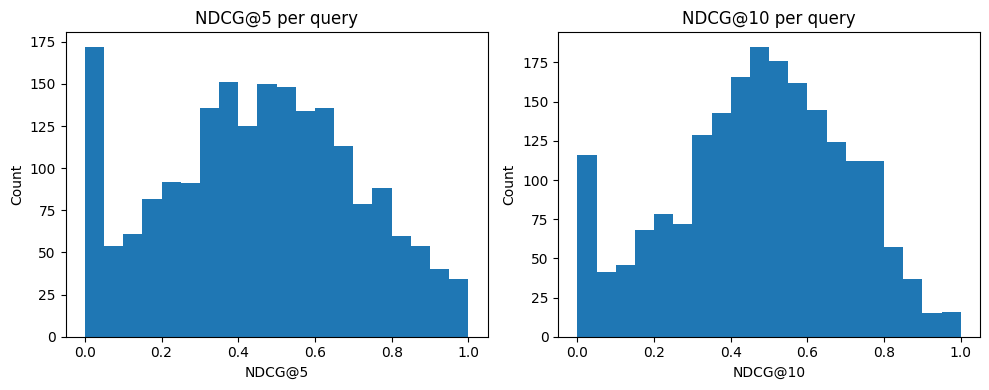

In [15]:
# ==========================================================
# 3.1 Ranking metrics: NDCG@5, NDCG@10 (per query)
# ==========================================================
def ndcg_at_k_per_query(df, k=10):
    """
    df: 包含 label, pred_score 的一个 query 下子表
    """
    g = df.sort_values("pred_score", ascending=False)
    rel = g["label"].values

    topk = rel[:k]
    gains = (2 ** topk - 1)
    discounts = np.log2(np.arange(2, len(topk) + 2))
    dcg = (gains / discounts).sum()

    ideal = np.sort(rel)[::-1][:k]
    gains_ideal = (2 ** ideal - 1)
    idcg = (gains_ideal / discounts).sum()

    if idcg == 0:
        return 0.0
    return float(dcg / idcg)

ndcg5_list = []
ndcg10_list = []

for q, g in df_summary.groupby("qid"):
    ndcg5_list.append(ndcg_at_k_per_query(g, k=5))
    ndcg10_list.append(ndcg_at_k_per_query(g, k=10))

print(f"Mean NDCG@5  (test): {np.mean(ndcg5_list):.4f}")
print(f"Mean NDCG@10 (test): {np.mean(ndcg10_list):.4f}")

# 可视化 NDCG 分布
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(ndcg5_list, bins=20)
axes[0].set_title("NDCG@5 per query")
axes[0].set_xlabel("NDCG@5")
axes[0].set_ylabel("Count")

axes[1].hist(ndcg10_list, bins=20)
axes[1].set_title("NDCG@10 per query")
axes[1].set_xlabel("NDCG@10")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [16]:
# ==========================================================
# 4. 转成 query_dict，拆 calib/test（完全复用原 demo）
# ==========================================================
query_dict = (
    df_summary.groupby("qid")[["doc_id", "label", "pred_score"]]
    .apply(lambda g: list(zip(g["doc_id"], g["label"], g["pred_score"])))
    .to_dict()
)
calib_dict_full, test_dict_full = split_query_dict(query_dict)
print(f"Number of calibration queries: {len(calib_dict_full)}")
print(f"Number of test queries:        {len(test_dict_full)}")

Number of calibration queries: 990
Number of test queries:        990


In [17]:
# ==========================================================
# 5. Compute FDP + λ̂ search（和原 demo 一样）
# ==========================================================
alpha = 0.3
delta = 0.1
lambda_step = 0.001
high_quality_threshold = 3  # MSLR-WEB10K: 0-4 scale, 3+ is highly relevant

lambda_value = 0.50
fdp_per_qid, summary = compute_fdp(calib_dict_full, lambda_value, label_threshold=high_quality_threshold)
print(f"λ = {lambda_value:.3f}")
print(f"Empirical FDR: {summary['mean_fdp']:.4f}")

mean_fdr_list = []
mean_size_list = []
mean_true_list = []
lambda_list = []
success = []
n_exp = 100

for i in range(n_exp):
    cal, test = split_query_dict(query_dict, random_state=42 + i)
    lam = find_lambda_hat(cal, delta, alpha, lambda_step)
    lambda_list.append(lam)

    _, summary = compute_fdp(test, lam, high_quality_threshold)
    fdr = summary["mean_fdp"]

    mean_fdr_list.append(fdr)
    mean_size_list.append(summary["mean_selected"])
    mean_true_list.append(summary["mean_true"])
    success.append(fdr <= alpha)

    if (i + 1) % 20 == 0 or i == 0:
        print(f"[{i+1:03d}/{n_exp}]  λ̂={lam:.3f}   meanFDR={fdr:.3f}")


λ = 0.500
Empirical FDR: 0.7455
[001/100]  λ̂=0.837   meanFDR=0.281
[020/100]  λ̂=0.848   meanFDR=0.249
[040/100]  λ̂=0.838   meanFDR=0.277
[060/100]  λ̂=0.838   meanFDR=0.277
[080/100]  λ̂=0.851   meanFDR=0.238
[100/100]  λ̂=0.834   meanFDR=0.292


In [18]:
# ==========================================================
# 6. Summary & 7. Plot
# ==========================================================
p_hat = np.mean(success)
print("\n================== Conformal FDR Summary ==================")
print(f"α (target FDR):              {alpha}")
print(f"δ (tolerance):               {delta}")
print(f"Target:                      P(FDR ≤ α) ≥ 1-δ = {1-delta:.3f}")
print(f"Empirical:                   P̂ = {p_hat:.3f}")
print(f"Mean FDR:                    {np.mean(mean_fdr_list):.3f} ± {np.std(mean_fdr_list):.3f}")
print(f"Mean set size:               {np.mean(mean_size_list):.2f} ± {np.std(mean_size_list):.2f}")
print("============================================================")



================== Conformal FDR Summary ==================
α (target FDR):              0.3
δ (tolerance):               0.1
Target:                      P(FDR ≤ α) ≥ 1-δ = 0.900
Empirical:                   P̂ = 0.960
Mean FDR:                    0.270 ± 0.018
Mean set size:               1.37 ± 0.14


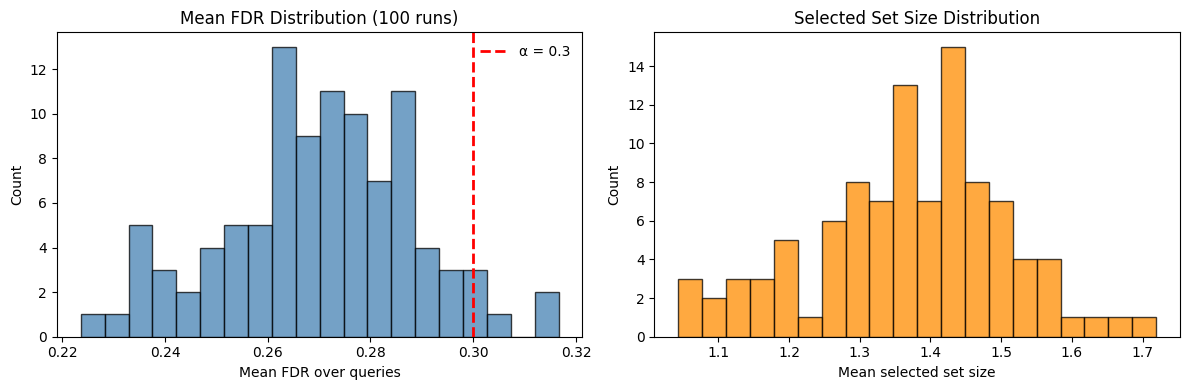

In [10]:
# -------------------------------------------------------------
# 7. Plots — Mean FDR and Set Size Distributions
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- (a) Mean FDR Distribution ---
axes[0].hist(
    mean_fdr_list,
    bins=20,
    color="steelblue",
    alpha=0.75,
    edgecolor="black"
)
axes[0].axvline(alpha, color="red", linestyle="--", linewidth=2, label=f"α = {alpha}")
axes[0].set_xlabel("Mean FDR over queries")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Mean FDR Distribution ({n_exp} runs)")
axes[0].legend(frameon=False)

# --- (b) Selected Set Size Distribution ---
axes[1].hist(
    mean_size_list,
    bins=20,
    color="darkorange",
    alpha=0.75,
    edgecolor="black"
)
axes[1].set_xlabel("Mean selected set size")
axes[1].set_ylabel("Count")
axes[1].set_title("Selected Set Size Distribution")

plt.tight_layout()
plt.show()
